# Extracting a Mapping from Symptoms to Physician Specialty from UMLS

The goal of this project is to build a chatbot for prediction of physician specialty type from symptoms and ultimately refer the user to a local physician. For that purpose, we first need to map the symptoms to a relevant discipline and thus a specialty. I start from a given list of specialists and traverse the UMLS network graph (where nodes are concepts and relations are edges) to reach symptoms. 
In UMLS database, there is no direct relation between specialist and sign and syptoms. First, I find the relation between specilist and biomedical occupation and discipline, and then find relation with disease and syndrome and at the end we can get the sign and symptoms information.

Below we can connect to our UMLS database already populated in MySQL. I am not using the MySQL database for this particular script, but we need to use it to work with the data more efficiently or to add more complicated features to the chatbot. The database is used in the chatbot for a faster real-time response.

In [1]:
import mysql.connector as mysql
db = mysql.connect(host = "localhost",user = "root",passwd = "123456",database="umls")
print(db)
cursor = db.cursor()
cursor.execute("SHOW DATABASES")
databases = cursor.fetchall()
print(databases)

cursor = db.cursor()

## getting all the tables which are present in database
cursor.execute("SHOW TABLES")

tables = cursor.fetchall()

[('information_schema',), ('mysql',), ('performance_schema',), ('sys',), ('umls',)]


Each concept in UMLS is assigned to one or more semantic types (categories), which are linked with one another through semantic relationships. Here, I build concept to semantic type dictioary using [MRSTY.RFF](https://www.ncbi.nlm.nih.gov/books/NBK9685/table/ch03.Tf/) file. 

In [2]:
UMLS = <Path to UMLS META>
mrsty_file = UMLS+"/MRSTY.RRF"
f= open(mrsty_file,"r")
l =f.readline()
con2sem={}
i=0
while(l):
    words = l.split("|")
    con2sem[words[0]]= words[1]
    l = f.readline()
f.close()
    

To find a mapping from specilist type to symptoms, we need to start from specilist types, find all `Biomedical Occupation or Discipline (T091)` semantics, then find all `Disease or Syndrome (T047)`, and finally reach to `Sign or Symptom (T184)`. There is a relation between all the semantic types and we are looking for relations [`RO`](https://www.nlm.nih.gov/research/umls/knowledge_sources/metathesaurus/release/abbreviations.html) and `RN`. `RO`: has relationship other than synonymous, narrower, or broader. `RN`: has a narrower relationship. 

This graph shows the mapping process:
<div>
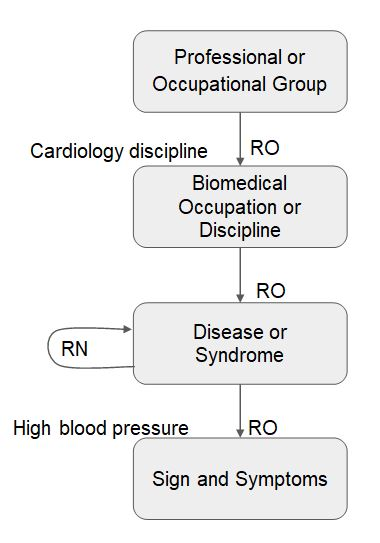
</div>

In [ ]:
from collections import defaultdict
rel_file = UMLS + "/MRREL.RRF"
f= open(rel_file,"r")
l =f.readline()
con2rel=defaultdict(list)
while(l):
    words = l.strip().split("|")
    if con2sem[words[0]] in ["T091","T047","T184"]:
        if words[3] in ["RO","RN"]:
            con2rel[words[0]].append(words[1:])
        l = f.readline()
f.close()

`findCUI` function returns all `Unique Identifier of Concep (CUI)` with a semantic type, that have a given relation with CUI

In [3]:
def findCUI(cui,semtype,reltype,cuilist):
    for rel in con2rel[cui]:
        cui2 = rel[3]
        if (con2sem[cui2]==semtype) & (rel[2]==reltype):
            cuilist.append(cui2)

These are the specialties that I will consider. More can be added to the list.

In [ ]:
specs = ["C0175906","C0237426","C0259831", \
         "C0259863","C0259901","C0260039","C0260087", \
         "C0260314","C0334889","C0237419",\
         "C1562236","C1562236","C0259901"] #pediatrics:"C0237433" -- oncologist:"C0259990"--
                    #psychiatrist:"C0260138"--Clinical immunologist:"C0334896"
                    #Anesthesiologist:"C0334910"--surgeon:
                    #Geriatrician:"C0586872","C0021782":internal medicine

Now lets use the above dictionaries to map the specialty to symptom.

In [ ]:
spec2symp={}
dis2symp={}
for cui1 in specs:
    cui_disc_list=[]
    findCUI(cui1,"T091","RO",cui_disc_list)#Biomedical occupation and discipline
    #if cui1== "C1704292":
     #   cui_disc_list=["C0015397"]
    print(cui_disc_list)
    if len(cui_disc_list)!=1:
        print("cui1 has %d disciplines for specialty %s )"%(len(cui_disc_list),cui1))
        print(cui_disc_list)
    cui_disc = cui_disc_list[0]
    disease_list=[]
    findCUI(cui_disc,"T047","RO",disease_list)
    if(len(disease_list)==0):
        print("no disease for %s found for specialty %s)"%(cui_disc,cui1))
    disease_list = list(set(disease_list))#keep unique
    
    disease2_list=[]
    for disease in disease_list:
        findCUI(disease,"T047","RN",disease2_list)
    disease2_list = list(set(disease2_list))
        
    symp_list_pool = []
    dis2symp[cui1]={}
    for disease2 in disease2_list:
        symp_list=[]
        findCUI(disease2,"T184","RO",symp_list)
        dis2symp[cui1][disease2]=symp_list
        symp_list_pool.extend(symp_list)
    spec2symp[cui1] = list(set(symp_list_pool))

['C0086343']
no disease for C0086343 found for specialty C0017319)


Here, we build a dictioonary for conversion of concept code to text using `MRCONSO` file.

In [ ]:
f = open(<path to MRCONSO.RRF>,'r')
l = f.readline()
con2word=defaultdict(list)
while(l):
    words = l.strip().split("|")
    if words[1]=="ENG":
        con2word[words[0]].append(words[14])
    l=f.readline()



Here I save the specialist and symptoms in a csv file to use it for building predictive model.

In [ ]:
txt=""
for sp,sylist in spec2symp.items():
    for sy in sylist:
        txt += "%s,%s\n"%(con2word[sp][0],con2word[sy][0])

f = open("specialist_symptoms_umls_symp.csv",'w')
f.write(txt)
f.close()



I also save symptoms and disease mapping just in case for a disease prediction model similar to [WebMD symptom checker](https://symptoms.webmd.com/)

In [ ]:
txt=""
for sp in dis2symp.keys():
    for dis in dis2symp[sp].keys():
        for sym in dis2symp[sp][dis]:
            txt += "%s,%s,%s\n"%(con2word[sp][0],con2word[dis][0],con2word[sym][0])

f = open("specialist_disease_symptoms_umls.csv",'w')
f.write(txt)
f.close()

I try to add more disease to our csv file. I find all disciplines.

In [272]:
all_disc=[]
for c in con2rel.keys():
    if con2sem[c]=="T091":
        all_disc.append(c)

In [273]:
for x in all_disc:
    print(con2word[x][0])
    

Acupuncture therapy discipline
Adolescent Medicine
Adolescent Psychiatry
Psychology, Adolescent
Aerospace Medicine
Allergy Specialty
Allergy and Immunology
Alternative Medicine
Science of Anatomy
Anatomy, Regional
Anatomy, Veterinary
Anesthesiology
Audiology
Bacteriology
Behavioral Medicine
Bioethics
Biological Psychiatry
biology (field)
Biomechanics
biomedical engineering field
Biopharmaceutics
Biophysics
Biotechnology
Cardiology discipline
Chemistry, Clinical
Chemistry, Pharmaceutical
Child Psychiatry
Psychology, Child
Chiropractic (field)
chronobiology (occupation)
Clinical Medicine
Colorectal Surgery Specialty
Community Dentistry
Community Health Nursing
Community Psychiatry
Cytogenetics
Cytology
Dentistry
Dentistry, Operative
Dermatology field
Dietetics
Electronics, Medical
Electrophysiology (science)
Embryology
emergency medicine (field)
Endocrinology
Endocrinology and Metabolism (Specialty)
Endodontics
Environment, Preventive Medicine and Public Health
Environmental Health
Epide

Here I remove disciplines not connected to any specialist.

In [274]:
all_disc2=[]
for cui in all_disc:
    spec_list=[]
    findCUI(cui,"T097","RO",spec_list)
    if len(spec_list)>0:

        all_disc2.append(cui)


disc2symp={}
for cui_disc in all_disc2:
    final_dlist=[]
    disease_list=[]
    disc2symp[cui_disc]={}
    findCUI(cui_disc,"T047","RO",disease_list)
    if(len(disease_list)==0):
        print("no disease found for discipline %s)"%(cui_disc))
        continue
    disease_list = list(set(disease_list))#keep unique
    final_dlist.extend(disease_list)
    
    disease2_list=[]
    for disease in disease_list:
        findCUI(disease,"T047","RN",disease2_list)
        if(len(disease2_list)==0):
            print("no disease level2 for %s found for discipline %s)"%(disease,cui_disc))
        else:#if narrower disease found use it  
            final_dlist.extend(disease2_list)
    final_dlist = list(set(final_dlist))
    
    
    for disease2 in final_dlist:
        symp_list=[]
        findCUI(disease2,"T184","RO",symp_list)
        if len(symp_list)==0:
            print("noc symptom found for disease %s"%disease2)
        else:
            disc2symp[cui_disc][disease2]=symp_list





no disease found for discipline C0001581)
no disease level2 for C0011119 found for discipline C0001713)
noc symptom found for disease C0011119
no disease found for discipline C0002111)
no disease found for discipline C0002112)
no disease found for discipline C0002930)
no disease found for discipline C0004285)
no disease found for discipline C0004644)
no disease found for discipline C0005489)
no disease found for discipline C0005532)
no disease found for discipline C0005539)
noc symptom found for disease C0340419
noc symptom found for disease C1852540
noc symptom found for disease C0553983
noc symptom found for disease C0151517
noc symptom found for disease C0007194
noc symptom found for disease C0007780
noc symptom found for disease C0348668
noc symptom found for disease C0010051
noc symptom found for disease C0149766
noc symptom found for disease C0032807
noc symptom found for disease C0017086
noc symptom found for disease C0079102
noc symptom found for disease C0600502
noc symptom fo

noc symptom found for disease C0018022
noc symptom found for disease C0242292
noc symptom found for disease C0018050
noc symptom found for disease C0011847
noc symptom found for disease C0392318
noc symptom found for disease C0349368
noc symptom found for disease C0162283
noc symptom found for disease C0020459
noc symptom found for disease C0342114
noc symptom found for disease C0040156
noc symptom found for disease C0011849
noc symptom found for disease C0039584
noc symptom found for disease C0020655
noc symptom found for disease C0024586
noc symptom found for disease C0235454
noc symptom found for disease C0040115
noc symptom found for disease C0162299
noc symptom found for disease C0271535
noc symptom found for disease C0263504
noc symptom found for disease C0342122
noc symptom found for disease C0342127
noc symptom found for disease C0151467
noc symptom found for disease C0677501
noc symptom found for disease C0018418
noc symptom found for disease C0020550
noc symptom found for dis

noc symptom found for disease C0019069
noc symptom found for disease C0949683
noc symptom found for disease C0950123
noc symptom found for disease C0013902
no disease found for discipline C0017467)
no disease found for discipline C0017469)
noc symptom found for disease C0341858
noc symptom found for disease C0869280
noc symptom found for disease C0156383
noc symptom found for disease C0013927
noc symptom found for disease C0016034
noc symptom found for disease C0007867
noc symptom found for disease C0156377
noc symptom found for disease C0156400
noc symptom found for disease C0156421
noc symptom found for disease C1400809
noc symptom found for disease C0014173
noc symptom found for disease C0022783
noc symptom found for disease C0042139
noc symptom found for disease C0042996
noc symptom found for disease C0151864
noc symptom found for disease C0024894
noc symptom found for disease C0235680
noc symptom found for disease C0030785
noc symptom found for disease C0149836
noc symptom found f

noc symptom found for disease C0030332
noc symptom found for disease C0008526
noc symptom found for disease C0796076
noc symptom found for disease C0152258
noc symptom found for disease C0014238
noc symptom found for disease C0029077
noc symptom found for disease C0596551
noc symptom found for disease C0154777
noc symptom found for disease C0155137
noc symptom found for disease C0155361
noc symptom found for disease C0598723
noc symptom found for disease C0036416
noc symptom found for disease C0028841
noc symptom found for disease C0034124
noc symptom found for disease C0155367
noc symptom found for disease C0008521
noc symptom found for disease C0042161
noc symptom found for disease C0029590
noc symptom found for disease C0030343
noc symptom found for disease C1832592
noc symptom found for disease C1857802
noc symptom found for disease C0155358
noc symptom found for disease C0035309
noc symptom found for disease C0242225
noc symptom found for disease C0022578
noc symptom found for dis

In [275]:
l=[]
d=[]
for k in disc2symp.keys():
    for k2 in disc2symp[k]:
        print(con2word[k][0],con2word[k2][0],disc2symp[k][k2])
        l.append(k)
        d.append(k2)
        

Cardiology discipline Coronary Artery Disease ['C0002962', 'C0002962']
Cardiology discipline Vascular Diseases ['C0002962', 'C0016382', 'C0235218', 'C0235524']
Cardiology discipline Arteriosclerosis ['C0002962']
Cardiology discipline heart overload ['C0002962']
Cardiology discipline Portal Hypertension ['C0037089']
Cardiology discipline Hyperemia ['C0027424', 'C0029625', 'C0034915']
Cardiology discipline Angina Pectoris, Variant ['C0348588']
Cardiology discipline Myocardial Infarction ['C0002962', 'C0002962']
Cardiology discipline Retinal Artery Occlusion ['C0149793']
Cardiology discipline Postural syncope ['C0259813', 'C0312422']
Cardiology discipline Purpura ['C0241144']
Cardiology discipline Cerebrovascular accident ['C0036572']
Cardiology discipline Deep thrombophlebitis ['C0238883']
Cardiology discipline Angina, Unstable ['C0002962']
Cardiology discipline Cardiovascular Diseases ['C0013404', 'C0029854', 'C0159049', 'C0553668']
Cardiology discipline Sudden infant death syndrome ['C

In [107]:
len(set(d))

216

I add internal medicine disease and symptoms to the csv file.

In [237]:
symp_list_pool = []
dis2symp={}
#internal medicine specialty 
spec=["C0021782"]
for cui1 in spec:
    final_dlist = ["C0004096", "C0020538","C0021400", "C0149931"]    
    for disease2 in final_dlist:
        symp_list=[]
        findCUI(disease2,"T184","RO",symp_list)
        disease2_list = list(set(disease2_list))
        if len(symp_list)==0:
            print("noc symptom found for disease %s"%disease2)
        else:
            disc2symp[cui1][disease2]=symp_list
            symp_list_pool.extend(symp_list)
            disc2symp=symp_list_pool
            print(disc2symp)  

['C0013404', 'C0037763', 'C0043144', 'C0231875', 'C0553668']
['C0013404', 'C0037763', 'C0043144', 'C0231875', 'C0553668', 'C0002962']
['C0013404', 'C0037763', 'C0043144', 'C0231875', 'C0553668', 'C0002962', 'C0392171', 'C0392389']
['C0013404', 'C0037763', 'C0043144', 'C0231875', 'C0553668', 'C0002962', 'C0392171', 'C0392389', 'C0018681', 'C0018681', 'C0018681', 'C0027497', 'C0235068']


In [238]:
txt=""

for sp in spec:
    for dis in final_dlist:
        for symp in symp_list:
            txt += "%s,%s,%s\n"%(con2word[sp][0],con2word[dis][0],con2word[symp][0])       

f = open("internalmedicine_disease_symptoms_umls.csv",'w')
f.write(txt)
f.close()